In [2]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [3]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy().reshape((X_train.shape[0], 1)).astype(np.int32)

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy().reshape((X_train.shape[0], 1)).astype(np.int32)

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy().reshape((X_train.shape[0], 1)).astype(np.int32)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800, 1)
(800, 7)
(800, 1)
(800, 7)
(800, 1)


# Model Implementation

In [5]:
def gini(sequence):
    _, cnt = np.unique(sequence, return_counts=True)
    prob = cnt / sequence.shape[0]
    g = 1 - np.sum([p**2 for p in prob])
    return g


def entropy(sequence):
    _, cnt = np.unique(sequence, return_counts=True)
    prob = cnt / sequence.shape[0]
    e = -1 * np.sum([p*np.log2(p) for p in prob])
    return e

In [6]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self):       
        self.feature = None
        self.threshold = None
        #self.impurity = None
        #self.data_num = None
        self.root = None
        self.left = None
        self.right = None
        self.predict_class = None        
        pass    


In [7]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        if max_features is None:
            self.max_features = 7
        else:
            self.max_features = max_features

        self.importance = {}

        self.tree_root = None

        self.pred = None

    def thresh(self, data, sample_weight=None):
        min_impurity = 1e9
        threshold = 0
        feature = 0
        (tuples, features) = data.shape
        #對每個feature做運算，找出可以到最小的impurity的feature及threshold
        for i in range(features-1):
            d_sorted = np.asarray(sorted(data, key=lambda t: t[i]))
            for j in range(1, tuples):
                thre = (d_sorted[j-1, i] + d_sorted[j, i]) / 2
                #thre = round(thre, 4)
                #根據feature及threshold把X分成兩邊
                d_left = d_sorted[d_sorted[:, i] < thre]
                d_right = d_sorted[d_sorted[:, i] >= thre]
                #計算左右的impurity
                im_left = self.criterion(d_left[:, -1])
                im_right = self.criterion(d_right[:, -1])
                #整體的impurity
                impurity = im_left * len(d_left)
                impurity += im_right * len(d_right)
                impurity /= tuples

                if impurity < min_impurity:
                    min_impurity = impurity
                    threshold = thre
                    feature = i
        
        return feature, threshold

    def build_tree(self, data, level, fid):
        root = Tree()
        if self.criterion(data[:, -1]) <= 0:
            root.predict_class = data[0, -1]
        elif level <= 0:
            label, cnt = np.unique(data[:, -1], return_counts=True)
            root.predict_class = label[np.argmax(cnt)]
        else:
            feature, thre = self.thresh(data)
            self.importance[f'feature{fid[feature]+1}'] += 1
            root.feature = fid[feature]
            root.threshold = thre
            d_left = data[data[:, feature] <= thre]
            d_right = data[data[:, feature] > thre]
            if len(d_left) == len(data) or len(d_left) == len(data):
                label, cnt = np.unique(data[:, -1], return_counts=True)
                root.predict_class = label[np.argmax(cnt)]
            else:
                root.left = self.build_tree(d_left, level-1, fid)
                root.right = self.build_tree(d_right, level-1, fid)
            
        return root

    def fit(self, X, y, sample_weight = None):
        self.tree_root = Tree()
        if self.max_features != 7:
            #隨機選max_features個features
            feature_index = np.random.choice(X.shape[1], self.max_features, replace=False)
            X = X[:, feature_index]
        else:
            feature_index = np.arange(X.shape[1])
        
        self.importance = {f'feature{i+1}': 0 for i in feature_index}

        data = np.concatenate((X, y), axis=1)
        self.tree_root = self.build_tree(data, self.max_depth, feature_index)

    def search(self, X, node):
        #到leaf
        if node.predict_class != None:
            return node.predict_class
        
        if X[node.feature] < node.threshold:
            return self.search(X, node.left)
        else:
            return self.search(X, node.right)

    def predict(self, X):
        self.pred = np.zeros(len(X), dtype=np.float64)
        for i in range(len(X)):
            self.pred[i] = self.search(X[i], self.tree_root)
        return self.pred
    
    def countImportance(self):
        sort_importance = sorted(self.importance.items(), key = lambda x: x[1])
        sort_importance = dict(sort_importance)
        plt.barh(list(sort_importance.keys()), list(sort_importance.values()), color='blue')
         
        pass

In [8]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        if max_features != None:
            self.max_features = np.round(max_features).astype(np.int32)
        else:
            self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth

        self.dt = []
        
    def fit(self, X, y):
        #np.random.seed(seed)        
        for i in range(self.n_estimators):            
            if self.boostrap == True:
                data_index = np.random.randint(low=0, high=X.shape[0], size=np.round(X.shape[0] * 2 / 3).astype(np.int32))
                partial_x = X[data_index]
                partial_y = y[data_index]
            else:
                partial_x = X
                partial_y = y
            #print(f'feature_index: {feature_index}, shape: {partial_feature.shape}, shape2: {partial_x.shape}')
            #print(f'partial feature: {partial_feature.all()}, partial x: {partial_x.all()}')

            T = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            T.fit(partial_x, partial_y)
            self.dt.append(T)

    def predict(self, X):
        # majority vote
        prediction = np.zeros((self.n_estimators, len(X)), dtype=np.float64)
        vote = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            prediction[i] = (self.dt[i].predict(X))
        
        for j in range(X.shape[0]):
            label, cnt = np.unique(prediction[:, j], return_counts=True)
            vote[j] = label[np.argmax(cnt)]
        return vote    

# Questions for Decision Tree

In [9]:
# For Q1

ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")


['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [10]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)


Q2-1 max_depth=3:  0.73125


In [11]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"


In [12]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight=None)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))


Q2-2 max_depth=10:  0.86375


In [13]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train, sample_weight=None)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))



Q3-1 criterion='gini':  0.73125


In [14]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train, sample_weight=None)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))


Q3-2 criterion='entropy':  0.7725


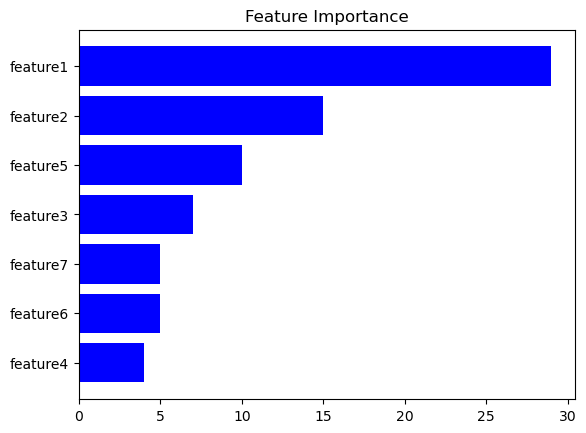

In [15]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight = None)

labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']
dt_depth10.countImportance()
plt.title('Feature Importance')

plt.show()

# Questions for Random Rorest

In [16]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

seed = 11
np.random.seed(seed)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))


Q6-1 n_estimators=10:  0.8825


In [17]:
# For Q6-2, validation accuracy should be higher than or equal to 0.89
seed = 20
np.random.seed(seed)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.89875


In [18]:
# For Q7-1, validation accuracy should be higher than or equal to 0.88
seed = 30
np.random.seed(seed)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.88375


In [19]:
# For Q7-2, validation accuracy should be higher than or equal to 0.86
seed = 40
np.random.seed(seed)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-2 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-2 max_features='All':  0.87875


# Train your own model

In [20]:
# Build and train your model
#seed 54: 0.90625, n_estimators=28, max_features=4, boostrap=True, criterion='entropy', max_depth=25, (2/3)
seed = 54
np.random.seed(seed)
your_model = RandomForest(n_estimators=28, max_features=4, boostrap=True, criterion='entropy', max_depth=25)
your_model.fit(X_train, y_train)
print("your_model: ", accuracy_score(y_val, your_model.predict(X_val)))
    
    

your_model:  0.90625


In [21]:

test_pred = your_model.predict(X_test)

print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [22]:
# output csv

df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")
